<a href="https://colab.research.google.com/github/Anya-Gupta-05/Predicting_Top11_Cricket_Players/blob/main/TOP11_Players_Cricsheet_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving t20s_json.zip to t20s_json.zip


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



In [ ]:
import zipfile
import os

# Replace with your actual uploaded filename
zip_path = "t20s_json.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("t20_data")  # Extracts into a folder named 't20_data'


In [ ]:
import os

json_files = os.listdir("t20_data")
print(json_files[:5])  # Print first 5 files for sanity check


['391794.json', '895789.json', '1425651.json', '1432225.json', '1479933.json']


In [ ]:
import json
import pandas as pd

# Example: load the first JSON file
file_path=os.path.join("t20_data",json_files[0])
with open(file_path,'r') as f:
  data=json.load(f)

import pprint
pprint.pprint(data.keys())

dict_keys(['meta', 'info', 'innings'])


In [ ]:

# Directory with extracted JSONs
json_dir = "t20_data"

# Store all records
records = []

for file in os.listdir(json_dir):
    if not file.endswith(".json"):
        continue

    path = os.path.join(json_dir, file)

    with open(path, 'r') as f:
        data = json.load(f)

    teams = data['info']['teams']
    if 'India' not in teams:
        continue  # Skip if India didn't play

    match_date = data['info'].get('dates', [None])[0]
    venue = data['info'].get('venue', None)
    opposition = [team for team in teams if team != 'India'][0]

    # Loop through innings
    for inning in data['innings']:
        team_name = inning['team']
        deliveries = inning['overs'] if 'overs' in inning else inning['deliveries']

        for over in deliveries:
            for delivery in over.get('deliveries', []) if isinstance(over, dict) and 'deliveries' in over else [over]:
                # Batsman data
                batsman = delivery['batter']
                runs = delivery['runs']['batter']
                total_runs = delivery['runs']['total']
                non_boundary = 0 if delivery['runs']['batter'] >= 4 else 1

                # Wicket data
                wicket = delivery.get('wickets', [])
                dismissed = None
                if wicket:
                    dismissed = wicket[0].get('player_out')

                # Bowler data
                bowler = delivery['bowler']
                bowler_runs = delivery['runs']['total']
                is_wicket = 1 if wicket else 0

                # Only include Indian players
                if team_name == 'India' or bowler in teams:
                    if team_name == 'India':
                        records.append({
                            'player': batsman,
                            'runs': runs,
                            'balls': 1,
                            'dismissed': dismissed,
                            'opponent': opposition,
                            'date': match_date,
                            'venue': venue,
                            'type': 'batting'
                        })
                    if bowler in teams and team_name != 'India':  # Bowler is Indian, team is opposition
                        records.append({
                            'player': bowler,
                            'runs_conceded': bowler_runs,
                            'wicket': is_wicket,
                            'balls_bowled': 1,
                            'opponent': team_name,
                            'date': match_date,
                            'venue': venue,
                            'type': 'bowling'
                        })

# Convert to DataFrame
df_india = pd.DataFrame(records)
print(df_india)


                  player  runs  balls dismissed    opponent        date  \
0                  M Raj     0      1      None   Australia  2016-01-29   
1                  M Raj     0      1      None   Australia  2016-01-29   
2                  M Raj     0      1      None   Australia  2016-01-29   
3                  M Raj     0      1      None   Australia  2016-01-29   
4                  M Raj     0      1      None   Australia  2016-01-29   
...                  ...   ...    ...       ...         ...         ...   
43891  Washington Sundar     0      1      None  Bangladesh  2019-11-03   
43892          KH Pandya     1      1      None  Bangladesh  2019-11-03   
43893  Washington Sundar     6      1      None  Bangladesh  2019-11-03   
43894  Washington Sundar     1      1      None  Bangladesh  2019-11-03   
43895          KH Pandya     6      1      None  Bangladesh  2019-11-03   

                          venue     type  
0      Melbourne Cricket Ground  batting  
1      Melbou

In [ ]:

from datetime import datetime

# Convert date column to datetime format
df_india['date'] = pd.to_datetime(df_india['date'])
# Define the cutoff date (5 years ago from today)
cutoff_date = pd.to_datetime("2020-06-10")

# Filter the DataFrame
df_last5 = df_india[df_india['date'] >= cutoff_date]
print(df_last5['date'].min())  # Should be around mid-2020 or later
print(df_last5.shape)          # Check number of rows




2020-12-04 00:00:00
(20594, 8)


In [ ]:
df_last5.head()

,player,runs,balls,dismissed,opponent,date,venue,type
301,RG Sharma,6,1,None,England,2021-03-18,Narendra Modi Stadium,batting
302,RG Sharma,0,1,None,England,2021-03-18,Narendra Modi Stadium,batting
303,RG Sharma,4,1,None,England,2021-03-18,Narendra Modi Stadium,batting
304,RG Sharma,0,1,None,England,2021-03-18,Narendra Modi Stadium,batting
305,RG Sharma,1,1,None,England,2021-03-18,Narendra Modi Stadium,batting


In [ ]:
df_last5.info()
df_last5.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 20594 entries, 301 to 43482
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   player     20594 non-null  object        
 1   runs       20594 non-null  int64         
 2   balls      20594 non-null  int64         
 3   dismissed  961 non-null    object        
 4   opponent   20594 non-null  object        
 5   date       20594 non-null  datetime64[ns]
 6   venue      20594 non-null  object        
 7   type       20594 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 1.4+ MB


,0
player,0
runs,0
balls,0
dismissed,19633
opponent,0
date,0
venue,0
type,0


In [ ]:
print("Total unique players:", df_last5['player'].nunique())
print(df_last5['player'].value_counts().head(10))  # Top 10 players


Total unique players: 92
player
S Mandhana       1677
SA Yadav         1581
Shafali Verma    1311
H Kaur           1204
JI Rodrigues     1143
HH Pandya        1067
V Kohli           965
RG Sharma         896
Ishan Kishan      669
RM Ghosh          668
Name: count, dtype: int64


In [ ]:
print("Total matches:", df_last5[['date', 'opponent']].drop_duplicates().shape[0])


Total matches: 180


In [ ]:
batting_df = df_last5[df_last5['type'] == 'batting']
runs_by_player = batting_df.groupby('player')['runs'].sum().sort_values(ascending=False)
print(runs_by_player.head(10))


player
SA Yadav         2543
S Mandhana       2058
Shafali Verma    1558
HH Pandya        1435
H Kaur           1404
JI Rodrigues     1337
RG Sharma        1255
V Kohli          1219
RM Ghosh          942
SV Samson         826
Name: runs, dtype: int64


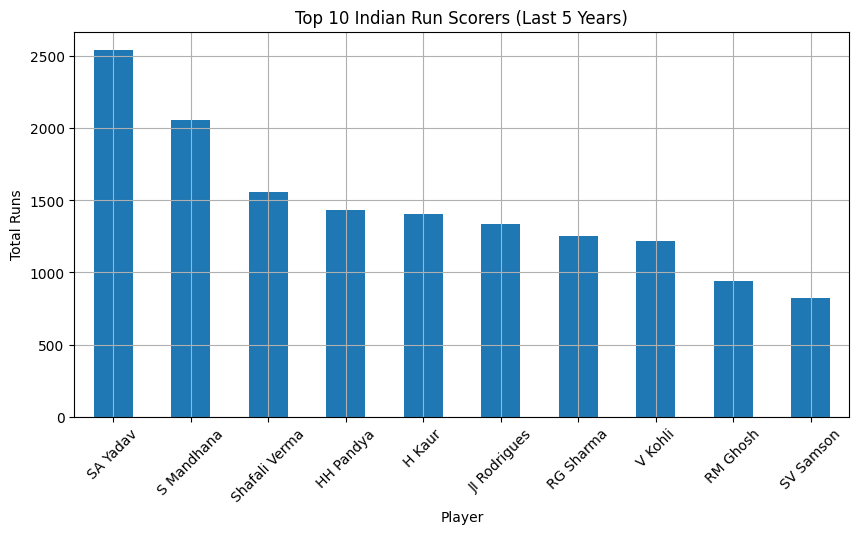

In [ ]:
import matplotlib.pyplot as plt

runs_by_player.head(10).plot(kind='bar', figsize=(10, 5), title='Top 10 Indian Run Scorers (Last 5 Years)')
plt.ylabel("Total Runs")
plt.xlabel("Player")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [ ]:
df_last5.to_csv("india_last5_years.csv", index=False)
from google.colab import files
files.download("india_last5_years.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Get sorted list of unique player names
unique_players = sorted(df_last5['player'].unique())

# Print each with an index to help manual selection
for i, player in enumerate(unique_players):
    print(f"{i+1}. {player}")


1. A Reddy
2. AB Kaur
3. AR Patel
4. Abhishek Sharma
5. Arshdeep Singh
6. Avesh Khan
7. B Kumar
8. C Sakariya
9. CV Varun
10. D Hemalatha
11. D Padikkal
12. DB Sharma
13. DJ Hooda
14. DL Chahar
15. DP Vaidya
16. Dhruv Jurel
17. H Deol
18. H Kaur
19. HH Pandya
20. HV Patel
21. Ishan Kishan
22. JI Rodrigues
23. JJ Bumrah
24. JM Sharma
25. K Anjali Sarvani
26. KD Karthik
27. KH Pandya
28. KK Ahmed
29. KL Rahul
30. KP Navgire
31. KS Ahuja
32. Kuldeep Yadav
33. M Mani
34. MK Pandey
35. MP Yadav
36. Meghna Singh
37. Mohammed Shami
38. Mohammed Siraj
39. Mukesh Kumar
40. N Rana
41. Navdeep Saini
42. Nithish Kumar Reddy
43. P Vastrakar
44. PP Shaw
45. Poonam Yadav
46. R Ashwin
47. R Parag
48. RA Jadeja
49. RA Tripathi
50. RD Chahar
51. RD Gaikwad
52. RG Sharma
53. RK Singh
54. RM Ghosh
55. RP Yadav
56. RR Pant
57. RS Gayakwad
58. Raghvi Bist
59. Ramandeep Singh
60. Ravi Bishnoi
61. Renuka Singh
62. S Asha
63. S Dhawan
64. S Dube
65. S Ishaque
66. S Mandhana
67. S Meghana
68. S Pandey
69. S Ran

In [ ]:
female_players = [
    "A Reddy",         # Anjali Reddy
    "AB Kaur",         # Amanjot Kaur
    "D Hemalatha",
    "DP Vaidya",
    "H Deol",          # Harleen Deol
    "H Kaur",          # Harmanpreet Kaur
    "JI Rodrigues",    # Jemimah Rodrigues
    "K Anjali Sarvani",
    "KP Navgire",      # Kiran Prabhu Navgire
    "M Mani",          # Minnu Mani
    "MK Pandey",       # Mandhana Pandey or possible confusion with Manish Pandey (keep if sure it's male)
    "MP Yadav",        # Might be Monika Patel Yadav
    "Meghna Singh",
    "P Vastrakar",     # Pooja Vastrakar
    "Poonam Yadav",
    "RM Ghosh",        # Richa Ghosh
    "RS Gayakwad",     # Rajeshwari Gayakwad
    "Raghvi Bist",
    "Renuka Singh",
    "S Asha",
    "S Ishaque",
    "S Mandhana",      # Smriti Mandhana
    "S Meghana",       # Sabbhineni Meghana
    "S Pandey",        # Shikha Pandey
    "S Sajana",
    "SD Bahadur",
    "SR Patil",        # Sushma Patil?
    "SZ Thakor",
    "Shafali Verma",
    "T Bhatia",        # Taniya Bhatia
    "TR Sadhu",
    "U Chetry",        # Uma Chetry
    "YH Bhatia"        # Yastika Bhatia
]
df_last5 = df_last5[~df_last5['player'].isin(female_players)]


In [ ]:
print("Remaining unique players:", df_last5['player'].nunique())
print(sorted(df_last5['player'].unique()))


Remaining unique players: 59
['AR Patel', 'Abhishek Sharma', 'Arshdeep Singh', 'Avesh Khan', 'B Kumar', 'C Sakariya', 'CV Varun', 'D Padikkal', 'DB Sharma', 'DJ Hooda', 'DL Chahar', 'Dhruv Jurel', 'HH Pandya', 'HV Patel', 'Ishan Kishan', 'JJ Bumrah', 'JM Sharma', 'KD Karthik', 'KH Pandya', 'KK Ahmed', 'KL Rahul', 'KS Ahuja', 'Kuldeep Yadav', 'Mohammed Shami', 'Mohammed Siraj', 'Mukesh Kumar', 'N Rana', 'Navdeep Saini', 'Nithish Kumar Reddy', 'PP Shaw', 'R Ashwin', 'R Parag', 'RA Jadeja', 'RA Tripathi', 'RD Chahar', 'RD Gaikwad', 'RG Sharma', 'RK Singh', 'RP Yadav', 'RR Pant', 'Ramandeep Singh', 'Ravi Bishnoi', 'S Dhawan', 'S Dube', 'S Rana', 'SA Yadav', 'SN Thakur', 'SS Iyer', 'SV Samson', 'Shivam Mavi', 'Shubman Gill', 'Tilak Varma', 'UT Yadav', 'Umran Malik', 'V Kohli', 'VR Iyer', 'Washington Sundar', 'YBK Jaiswal', 'YS Chahal']


In [ ]:
print(df_last5.head())

        player  runs  balls dismissed opponent       date  \
301  RG Sharma     6      1      None  England 2021-03-18   
302  RG Sharma     0      1      None  England 2021-03-18   
303  RG Sharma     4      1      None  England 2021-03-18   
304  RG Sharma     0      1      None  England 2021-03-18   
305  RG Sharma     1      1      None  England 2021-03-18   

                     venue     type  
301  Narendra Modi Stadium  batting  
302  Narendra Modi Stadium  batting  
303  Narendra Modi Stadium  batting  
304  Narendra Modi Stadium  batting  
305  Narendra Modi Stadium  batting  


In [ ]:
df_last5.to_csv("india_last5_years.csv", index=False)
from google.colab import files
files.download("india_last5_years.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
type_counts = df_last5.groupby(['player', 'type']).size().unstack(fill_value=0)


In [ ]:
df_model = df_last5[['player', 'runs', 'balls', 'opponent', 'date', 'type']]  # you can customize this
df_model['opponent'] = LabelEncoder().fit_transform(df_model['opponent'])
df_model['type'] = LabelEncoder().fit_transform(df_model['type'])

<ipython-input-31-5d7f633ad0d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['opponent'] = LabelEncoder().fit_transform(df_model['opponent'])
<ipython-input-31-5d7f633ad0d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['type'] = LabelEncoder().fit_transform(df_model['type'])


In [ ]:
df_model = df_model.sort_values(by=['player', 'date'])


In [ ]:
sequence_length = 5
player_sequences = []

grouped = df_model.groupby('player')

for player, group in grouped:
    group = group.reset_index(drop=True)
    for i in range(len(group) - sequence_length):
        sequence = group.iloc[i:i+sequence_length][['runs', 'balls', 'opponent', 'type']].values
        target = group.iloc[i+sequence_length]['runs']  # or a binary flag (in top 11 = 1)
        player_sequences.append((sequence, target))


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array([seq for seq, _ in player_sequences])
y = np.array([target for _, target in player_sequences])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output: run prediction or score


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.2167 - mae: 1.3088 - val_loss: 2.9009 - val_mae: 1.2423
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.1781 - mae: 1.3698 - val_loss: 2.9106 - val_mae: 1.3097
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.0425 - mae: 1.3262 - val_loss: 2.8983 - val_mae: 1.2031
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.0430 - mae: 1.3114 - val_loss: 2.8905 - val_mae: 1.2442
Epoch 5/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.9896 - mae: 1.2939 - val_loss: 2.8922 - val_mae: 1.2500
Epoch 6/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0057 - mae: 1.3117 - val_loss: 2.8915 - val_mae: 1.2681
Epoch 7/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.9632 - mae: 1.3095 - val_loss: 2.9134 - val_mae: 1.3340
Epoch 8/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.0318 - mae: 1.3314 - val_loss: 2.8911 - val_mae: 1.2789
Epoch 9/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - l

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9675 - mae: 1.3195
Test MAE: 1.3345485925674438


In [ ]:
latest_sequences = []
latest_players = []

grouped = df_model.groupby('player')

for player, group in grouped:
    group = group.sort_values(by='date').reset_index(drop=True)

    if len(group) >= sequence_length:
        latest_seq = group.iloc[-sequence_length:][['runs', 'balls', 'opponent', 'type']].values
        latest_sequences.append(latest_seq)
        latest_players.append(player)


In [ ]:
latest_sequences = np.array(latest_sequences)
preds = model.predict(latest_sequences).flatten()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step


In [ ]:
# Pair players with their predicted values
player_scores = list(zip(latest_players, preds))

# Sort by predicted score descending
top_11 = sorted(player_scores, key=lambda x: x[1], reverse=True)[:11]

# Print results
print("🏏 Top 11 Predicted Players:")
for i, (player, score) in enumerate(top_11, 1):
    print(f"{i}. {player} — Predicted Score: {score:.2f}")


🏏 Top 11 Predicted Players:
1. R Parag — Predicted Score: 1.73
2. R Ashwin — Predicted Score: 1.70
3. SS Iyer — Predicted Score: 1.63
4. AR Patel — Predicted Score: 1.57
5. RA Tripathi — Predicted Score: 1.55
6. HV Patel — Predicted Score: 1.53
7. SV Samson — Predicted Score: 1.52
8. Abhishek Sharma — Predicted Score: 1.52
9. Tilak Varma — Predicted Score: 1.50
10. RK Singh — Predicted Score: 1.49
11. S Dube — Predicted Score: 1.46
